# 분석에 필요한 데이터 구성하기

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale # 데이터 scale
from datetime import datetime

%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
ds_currency = pd.read_csv("./Practice data/환율.CSV",engine="python",parse_dates = ["APPL_DATE"])
ds_currency.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


# 변동 추세 확인 - 시간에 따른 환율 추세 그래프 생성
- # 중국 위엔화, 엔화, 달러의 크기가 다르기 때문에 각각 그래프를 생성 -> 3행 1열, 크기: (10,8)

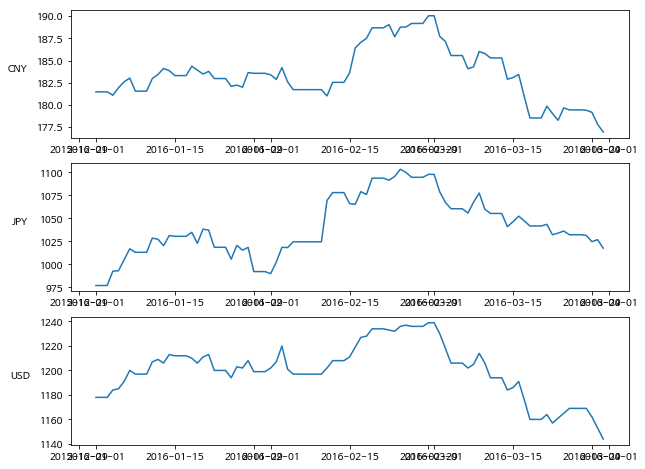

In [8]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10,8))
# zip 함수를 사용하면 zip 함수 안이ㅡ 리스트들을 하나씩 배출
# 1번 loop: ax1, 311, "CNY"
# 2번 loop: ax2, 312, "JPY"
# 3번 loop: ax3, 313, "USD"
for (ax,idx,currency) in zip([ax1,ax2,ax3],[311,312,313],["CNY","JPY","USD"]):
    #plot 추가, 311 -> 3행 1열의 1번 그래프
    ax.plot("APPL_DATE","STD_RATE",data=ds_currency[ds_currency["CURRENCY"]==currency])
    #y축에 통화 표시 -> rotation: label 가로로 생성, labelpad : label과 그래프 사이의 거리
    ax.set_ylabel(currency,rotation=0,labelpad=20)

In [10]:
#CNY 데이터 추출 후 APPL_DATE를 index로 설정
ds_currency_CNY =ds_currency[ds_currency["CURRENCY"]=="CNY"].set_index("APPL_DATE")
# drop method를 이용해 통화(CURRENCY)의 미달러 환산율(USD_CONV_DATE) 변수 제외
ds_currency_CNY.drop(["CURRENCY","USD_CONV_DATE"],axis=1,inplace=True)
# JPY 데이터 생성
ds_currency_JPY = ds_currency[ds_currency["CURRENCY"]=="JPY"].set_index("APPL_DATE")
ds_currency_JPY.drop(["CURRENCY","USD_CONV_DATE"],axis=1,inplace=True)
# USD 데이터 생성
ds_currency_USD = ds_currency[ds_currency["CURRENCY"]=="USD"].set_index("APPL_DATE")
ds_currency_USD.drop(["CURRENCY","USD_CONV_DATE"],axis=1,inplace=True)
ds_currency_CNY.head()

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94


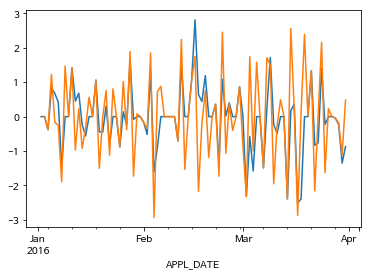

In [14]:
# 1번 차본 : z(t) - z(t-1)
# shift(n) 앞의 n번 째 행의 데이터를 가져옴
ds_cny_diff1 = ds_currency_CNY["STD_RATE"]-ds_currency_CNY["STD_RATE"].shift(1)
ds_cny_diff1.plot()

# 2번 차본 (z(t) - z(t-1)) - (z(t-1) - z(t-2)) = 2*z(t-1)+z(t-2)
# 코드가 길어질 경우 가독성을 위해 연산자 뒤에 "\"표시를 붙임으로써 하나의 문장을 두 문장으로 나눌 수 있음
ds_cny_diff2 = ds_currency_CNY["STD_RATE"]-2*(ds_currency_CNY["STD_RATE"].shift(1))+\
                                             (ds_currency_CNY["STD_RATE"].shift(2))
ds_cny_diff2.plot()